# Exercise Sheet 3: Multi Layer Perceptrons (MLPs)

In [369]:
import os

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from sklearn.datasets import make_moons

from tqdm import tqdm
import numpy as np
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (6.0, 4.0)

import pprint
pp = pprint.PrettyPrinter(indent=4)


# Set random seed for reproducibility
SEED = 42
RESULTS_PATH = "./results"

torch.manual_seed(SEED)
np.random.seed(SEED)

### Task 1: Backpropagation and Simple Training


For the linear layer we need two derivates towards the trainable parameters
\begin{align}
\frac{\partial f_j}{\partial b_j}&=1\\
\frac{\partial f_j}{\partial w_{ji}}&=x_i
\end{align}
and one towards the input
\begin{equation}
\frac{\partial f_j}{\partial x_i}=w_{ji}
\end{equation}


For the ReLU unit $g=\max\left(0,f\right)$ we have the following gradient:
\begin{equation}
\frac{\partial g}{\partial f}=
\begin{cases}
    1 & \text{if}~f>0\\
    0 & \text{if}~f<0
\end{cases}
\end{equation}
Keep in mind that the derivative at $f=0$ does not exists.

In [370]:
def standard_normalization(x):
    """Default normalization function. Normalizes the input x."""
    return (x - x.mean()) / x.std()

def moving_average(x, w):
    """Compute the moving average of x with window size w."""
    return np.convolve(x, np.ones(w), 'valid') / w

def normaldist_init(input_size, output_size):
    """Get some random numbers based on Normal Distribution to initialize weights."""
    # Normal distribution initialization
    return torch.randn(1, output_size, input_size)/(input_size + 1)
    
def xavier_init(input_size, output_size):
    """ Get some random number to initialize weights."""
    # Xavier initialization
    return torch.randn(input_size, output_size) * np.sqrt(2.0/(input_size + output_size))

In [371]:
# 1. Complete forward, backward pass, and update for Linear and ReLU
class Linear:
    def __init__(self, in_channels, out_channels):
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # initialize weights and biases
        # https://pytorch.org/docs/stable/nn.init.html
        self.weight = torch.randn(1, out_channels, in_channels)/(in_channels+1)
        self.bias = torch.zeros(1, out_channels)
        
        self.last_input = None
        self.grad_weight = None
        self.grad_bias = None
        
    def forward(self, x, remember=False):
        if remember:
            self.last_input = x

        # https://pytorch.org/docs/stable/generated/torch.einsum.html
        # https://stackoverflow.com/questions/55894693/understanding-pytorch-einsum    
        return torch.einsum("bji,bi->bj", self.weight, x) + self.bias
    
    def backward(self, gradient):
        self.grad_weight = torch.mean(torch.einsum("bj,bi->bji", gradient, self.last_input), dim=0)
        self.grad_bias = torch.mean(gradient, dim=0) # gradient * 1

        # return the grad to next layer
        # upper grad mm the grad towards the input
        return torch.einsum("bj,bji->bi", gradient, self.weight)
    
    def update(self, learning_rate):
        # gradient descent
        self.weight = self.weight - learning_rate*self.grad_weight
        self.bias = self.bias - learning_rate*self.grad_bias
        
        
class ReLU:
    def __init__(self):
        self.last_input = None
    
    def forward(self, x, remember=False):
        if remember:
            self.last_input = x
        
        # ReLU activation
        newx = torch.max(x, torch.zeros_like(x))
        return newx
    
    def backward(self, gradient):
        # ReLU gradient - check where input is larger than zero return 1, else 0
        newgrad = torch.where(self.last_input > 0, gradient, 0.0)
        return newgrad
    
    def update(self, learning_rate):
        # we don't have any parameters in ReLU layer here
        # other ReLU activations can have parameters that might need to be learned
        pass
    

In [372]:
class Softmax:
    """ Numerically stable Softmax implementation since we take the max() 
        of the input per samples not per batch. 
        We constrain it into a range of 0 to 1.
    """
    def __init__(self, dim=-1):
        self.last_output = None
        self.dim = dim
        
    def forward(self, x, remember=False):
        x = torch.exp(x - torch.amax(x, dim=-1, keepdims=True)) # numerical stable version -> normalize by max(x) over the last dimension
        x = x/(torch.sum(x, dim=self.dim, keepdim=True)+1e-12)
        if remember:
            self.last_output = x
        return x
    
    def backward(self, gradient):
        jacobian = -self.last_output[:,:,None]*self.last_output[:,None,:] #BxLxL
        #correct diagonal entries
        jacobian += torch.eye(self.last_output.size(-1)).unsqueeze(0)*self.last_output.unsqueeze(-1).repeat(1,1,self.last_output.size(-1))
        # you can use any character, but make sure they are consistent
        return torch.einsum("bj,bji->bi", gradient, jacobian)
    
    def update(self, learning_rate):
        #we don't have any parameters here
        pass

In [373]:
class CrossEntropyLoss:
    def __init__(self, dim=-1):
        self.last_input = None
        self.last_ground_truth = None
        self.dim = dim
    
    def forward(self, p, y):
        #convert y to one hot
        one_hot = torch.eye(p.size(-1))[y]
        self.last_input = p
        self.last_ground_truth = one_hot
        
        losses = -torch.sum(one_hot*torch.log(p), dim=-1)
        total_loss = torch.mean(losses)
        
        return total_loss
    
    def backward(self):
        return torch.where(self.last_ground_truth==1,-1.0/self.last_input, 0.0)

In [374]:
class MLP:
    def __init__(self, in_channels=2, hidden_channels=[], out_channels=2):
        self.in_channels = in_channels
        
        self.layers = []
        if len(hidden_channels)==0:
            self.layers.append(Linear(in_channels, out_channels))
        else:
            self.layers.append(Linear(in_channels, hidden_channels[0]))
            self.layers.append(ReLU())
            for i in range(len(hidden_channels)-1):
                self.layers.append(Linear(hidden_channels[i], hidden_channels[i+1]))
                self.layers.append(ReLU())
            self.layers.append(Linear(hidden_channels[-1], out_channels))
        self.layers.append(Softmax(dim=-1))
        
        self.criterion = CrossEntropyLoss(dim=-1)
        
    def forward(self, x, remember=False):
        for layer in self.layers:
            x = layer.forward(x, remember=remember)
        return x
    
    def backward(self): #calculate gradients
        grad = self.criterion.backward()
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def update(self, learning_rate): #update each layer via gradient descent
        for layer in self.layers:
            layer.update(learning_rate)
    
    def training_step(self, x, y, learning_rate):
        probabilities = self.forward(x, remember=True) #store inputs for backward pass!
        loss = self.criterion.forward(probabilities, y)
        self.backward() #calculate gradients
        self.update(learning_rate) #update using gradient descent
        
        return loss

In [375]:
def train_network(mlp, Ntrain, Ntest, Xtrain, ytrain, Xtest, ytest, num_epochs=10, batch_size=32, learning_rate=5e-3):
    num_batches_train = int(np.ceil(Ntrain/batch_size))
    num_batches_test = int(np.ceil(Ntest/batch_size))

    #train network
    losses_train = []
    losses_test = []
    
    for epoch in range(num_epochs):
        #reshuffle training data
        ind = np.random.permutation(len(Xtrain))
        Xtrain = Xtrain[ind]
        ytrain = ytrain[ind]

        #training pass
        for it in tqdm(range(num_batches_train)):
            start = it*batch_size
            end = min((it+1)*batch_size, len(Xtrain))
            X = torch.FloatTensor(Xtrain[start:end])
            y = torch.LongTensor(ytrain[start:end])

            # compute loss and update weights
            loss = mlp.training_step(X, y, learning_rate)
            losses_train.append(loss.item())

            # update weights
            mlp.update(learning_rate)

            if it%10==0:
                print(f"Epoch {epoch+1}/{num_epochs}, Iteration {it+1}/{num_batches_train}, Train Loss: {loss.item()}")

        #testing pass
        for it in tqdm(range(num_batches_test)):
            start = it*batch_size
            end = min((it+1)*batch_size, len(Xtest))
            X = torch.FloatTensor(Xtest[start:end])
            y = torch.LongTensor(ytest[start:end])

            # compute loss
            probabilities = mlp.forward(X)
            loss = mlp.criterion.forward(probabilities, y)
            losses_test.append(loss.item())

            if it%10==0:
                print(f"Epoch {epoch+1}/{num_epochs}, Iteration {it+1}/{num_batches_test}, Test Loss: {loss.item()}")


    return losses_train, losses_test


In [376]:
#create datasets
Ntrain = 8000
Ntest = 2000
Xtrain, ytrain = make_moons(n_samples=Ntrain, noise=0.1, random_state=42)
Xtest, ytest = make_moons(n_samples=Ntest, noise=0.1, random_state=42)

print(Xtrain.shape, ytrain.shape)

(8000, 2) (8000,)


In [377]:
# 2. Implement missing parts in the training routine

losses_train = []
losses_test = []

# rescale data (normalise) to [-1,1]
amin = np.amin(Xtrain, axis=0, keepdims=True)
amax = np.amax(Xtrain, axis=0, keepdims=True)

Xtrain = ((Xtrain-amin)/(amax-amin)-0.5)/0.5
Xtest = ((Xtest-amin)/(amax-amin)-0.5)/0.5

batch_size = 32
num_epochs = 10
learning_rate = 3e-2

# create MLP
hidden_channels = [30,30]
mlp = MLP(2, hidden_channels, 2)

# train network
losses_train, losses_test = train_network(mlp, Ntrain, Ntest, Xtrain, ytrain, Xtest, ytest, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate)


  0%|          | 0/250 [00:00<?, ?it/s]


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [1, 2] but got: [1, 30].

In [ ]:
def plot_loss_curves(losses_train, losses_test, path=RESULTS_PATH, file_name="losses"):
    plt.figure(figsize=(10, 6))

    plt.plot(losses_train, label="Train Loss")
    plt.plot(losses_test, label="Test Loss")

    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Loss Curves")

    plt.legend()
    plt.grid(True)
    plt.savefig(f"{path}/{file_name}.png", dpi=300)
    plt.show()

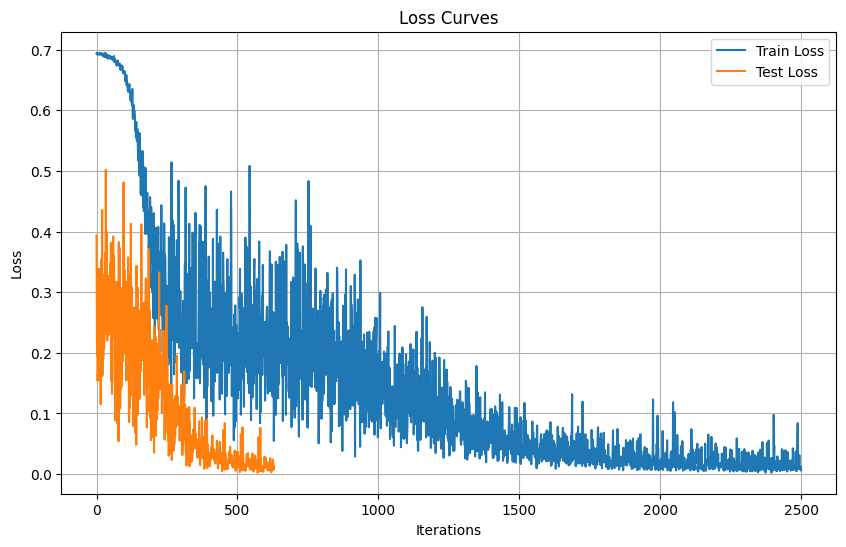

In [ ]:
# 3. Plot loss curves on training and test set
plot_loss_curves(losses_train, losses_test, file_name="mlp_loss_curves_small_2")

In [ ]:
# 4. Increase the number of hidden units and observe the effect on the loss curves
# create MLP
batch_size = 32
num_epochs = 10
learning_rate = 3e-2

hidden_channels = [30, 40, 50, 40, 30]
mlp = MLP(2, hidden_channels, 2)

losses_train = []
losses_test = []

# train network
losses_train, losses_test = train_network(mlp, Ntrain, Ntest, Xtrain, ytrain, Xtest, ytest, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate)

 81%|████████  | 203/250 [00:00<00:00, 1020.16it/s]

Epoch 1/10, Iteration 1/250, Train Loss: 0.6931473612785339
Epoch 1/10, Iteration 11/250, Train Loss: 0.6935967803001404
Epoch 1/10, Iteration 21/250, Train Loss: 0.6924042105674744
Epoch 1/10, Iteration 31/250, Train Loss: 0.6952605247497559
Epoch 1/10, Iteration 41/250, Train Loss: 0.697787344455719
Epoch 1/10, Iteration 51/250, Train Loss: 0.6936145424842834
Epoch 1/10, Iteration 61/250, Train Loss: 0.6920682191848755
Epoch 1/10, Iteration 71/250, Train Loss: 0.6924627423286438
Epoch 1/10, Iteration 81/250, Train Loss: 0.6906090974807739
Epoch 1/10, Iteration 91/250, Train Loss: 0.6942237019538879
Epoch 1/10, Iteration 101/250, Train Loss: 0.6935250759124756
Epoch 1/10, Iteration 111/250, Train Loss: 0.6918317079544067
Epoch 1/10, Iteration 121/250, Train Loss: 0.6931954622268677
Epoch 1/10, Iteration 131/250, Train Loss: 0.6926822662353516
Epoch 1/10, Iteration 141/250, Train Loss: 0.693088173866272
Epoch 1/10, Iteration 151/250, Train Loss: 0.6939719319343567
Epoch 1/10, Iteration

100%|██████████| 250/250 [00:00<00:00, 1024.80it/s]


Epoch 1/10, Iteration 211/250, Train Loss: 0.6900742053985596
Epoch 1/10, Iteration 221/250, Train Loss: 0.6828520894050598
Epoch 1/10, Iteration 231/250, Train Loss: 0.6956159472465515
Epoch 1/10, Iteration 241/250, Train Loss: 0.6942269802093506


100%|██████████| 63/63 [00:00<00:00, 5628.62it/s]


Epoch 1/10, Iteration 1/63, Test Loss: 0.6938198804855347
Epoch 1/10, Iteration 11/63, Test Loss: 0.69568932056427
Epoch 1/10, Iteration 21/63, Test Loss: 0.6919502019882202
Epoch 1/10, Iteration 31/63, Test Loss: 0.69568932056427
Epoch 1/10, Iteration 41/63, Test Loss: 0.6907038688659668
Epoch 1/10, Iteration 51/63, Test Loss: 0.6919502019882202
Epoch 1/10, Iteration 61/63, Test Loss: 0.6938198208808899


 44%|████▍     | 110/250 [00:00<00:00, 1095.68it/s]

Epoch 2/10, Iteration 1/250, Train Loss: 0.6950662136077881
Epoch 2/10, Iteration 11/250, Train Loss: 0.6928189992904663
Epoch 2/10, Iteration 21/250, Train Loss: 0.692820131778717
Epoch 2/10, Iteration 31/250, Train Loss: 0.6921668648719788
Epoch 2/10, Iteration 41/250, Train Loss: 0.6933687925338745
Epoch 2/10, Iteration 51/250, Train Loss: 0.6872819066047668
Epoch 2/10, Iteration 61/250, Train Loss: 0.691940188407898
Epoch 2/10, Iteration 71/250, Train Loss: 0.6942288875579834
Epoch 2/10, Iteration 81/250, Train Loss: 0.6919025778770447
Epoch 2/10, Iteration 91/250, Train Loss: 0.6903802156448364
Epoch 2/10, Iteration 101/250, Train Loss: 0.6951057314872742
Epoch 2/10, Iteration 111/250, Train Loss: 0.6922042369842529
Epoch 2/10, Iteration 121/250, Train Loss: 0.6933789849281311
Epoch 2/10, Iteration 131/250, Train Loss: 0.691235363483429
Epoch 2/10, Iteration 141/250, Train Loss: 0.6923664808273315
Epoch 2/10, Iteration 151/250, Train Loss: 0.6951093077659607
Epoch 2/10, Iteration 

100%|██████████| 250/250 [00:00<00:00, 898.91it/s] 


Epoch 2/10, Iteration 171/250, Train Loss: 0.68593430519104
Epoch 2/10, Iteration 181/250, Train Loss: 0.6849678754806519
Epoch 2/10, Iteration 191/250, Train Loss: 0.688723623752594
Epoch 2/10, Iteration 201/250, Train Loss: 0.6888027191162109
Epoch 2/10, Iteration 211/250, Train Loss: 0.6888303756713867
Epoch 2/10, Iteration 221/250, Train Loss: 0.6953034996986389
Epoch 2/10, Iteration 231/250, Train Loss: 0.6942875385284424
Epoch 2/10, Iteration 241/250, Train Loss: 0.6935816407203674


100%|██████████| 63/63 [00:00<00:00, 5371.85it/s]


Epoch 2/10, Iteration 1/63, Test Loss: 0.693815290927887
Epoch 2/10, Iteration 11/63, Test Loss: 0.6956725716590881
Epoch 2/10, Iteration 21/63, Test Loss: 0.6919577121734619
Epoch 2/10, Iteration 31/63, Test Loss: 0.6956726908683777
Epoch 2/10, Iteration 41/63, Test Loss: 0.6907193660736084
Epoch 2/10, Iteration 51/63, Test Loss: 0.6919577121734619
Epoch 2/10, Iteration 61/63, Test Loss: 0.6938151717185974


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/10, Iteration 1/250, Train Loss: 0.6925767660140991
Epoch 3/10, Iteration 11/250, Train Loss: 0.6979528665542603
Epoch 3/10, Iteration 21/250, Train Loss: 0.693394660949707
Epoch 3/10, Iteration 31/250, Train Loss: 0.693264365196228
Epoch 3/10, Iteration 41/250, Train Loss: 0.6923782825469971
Epoch 3/10, Iteration 51/250, Train Loss: 0.6931520104408264
Epoch 3/10, Iteration 61/250, Train Loss: 0.6920907497406006
Epoch 3/10, Iteration 71/250, Train Loss: 0.6927230358123779
Epoch 3/10, Iteration 81/250, Train Loss: 0.6901781558990479
Epoch 3/10, Iteration 91/250, Train Loss: 0.6922192573547363


 45%|████▌     | 113/250 [00:00<00:00, 1128.55it/s]

Epoch 3/10, Iteration 101/250, Train Loss: 0.6935642957687378
Epoch 3/10, Iteration 111/250, Train Loss: 0.6924428939819336
Epoch 3/10, Iteration 121/250, Train Loss: 0.6935684680938721
Epoch 3/10, Iteration 131/250, Train Loss: 0.6937647461891174
Epoch 3/10, Iteration 141/250, Train Loss: 0.6908614635467529
Epoch 3/10, Iteration 151/250, Train Loss: 0.6921080350875854
Epoch 3/10, Iteration 161/250, Train Loss: 0.6963340044021606
Epoch 3/10, Iteration 171/250, Train Loss: 0.6932254433631897
Epoch 3/10, Iteration 181/250, Train Loss: 0.6909180283546448
Epoch 3/10, Iteration 191/250, Train Loss: 0.6922398805618286
Epoch 3/10, Iteration 201/250, Train Loss: 0.6932287812232971
Epoch 3/10, Iteration 211/250, Train Loss: 0.6920149922370911


 91%|█████████ | 227/250 [00:00<00:00, 1128.93it/s]

Epoch 3/10, Iteration 221/250, Train Loss: 0.6855781674385071


100%|██████████| 250/250 [00:00<00:00, 1113.60it/s]


Epoch 3/10, Iteration 231/250, Train Loss: 0.6971484422683716
Epoch 3/10, Iteration 241/250, Train Loss: 0.6962466239929199


100%|██████████| 63/63 [00:00<00:00, 5737.14it/s]


Epoch 3/10, Iteration 1/63, Test Loss: 0.6928332448005676
Epoch 3/10, Iteration 11/63, Test Loss: 0.6918506622314453
Epoch 3/10, Iteration 21/63, Test Loss: 0.6938155293464661
Epoch 3/10, Iteration 31/63, Test Loss: 0.6918507814407349
Epoch 3/10, Iteration 41/63, Test Loss: 0.6944704055786133
Epoch 3/10, Iteration 51/63, Test Loss: 0.6938155889511108
Epoch 3/10, Iteration 61/63, Test Loss: 0.6928331851959229


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/10, Iteration 1/250, Train Loss: 0.6934880614280701
Epoch 4/10, Iteration 11/250, Train Loss: 0.6947176456451416
Epoch 4/10, Iteration 21/250, Train Loss: 0.6914538145065308
Epoch 4/10, Iteration 31/250, Train Loss: 0.6891761422157288
Epoch 4/10, Iteration 41/250, Train Loss: 0.6989028453826904
Epoch 4/10, Iteration 51/250, Train Loss: 0.6934589743614197
Epoch 4/10, Iteration 61/250, Train Loss: 0.6979078650474548
Epoch 4/10, Iteration 71/250, Train Loss: 0.6932971477508545
Epoch 4/10, Iteration 81/250, Train Loss: 0.6932888031005859


 45%|████▍     | 112/250 [00:00<00:00, 1113.02it/s]

Epoch 4/10, Iteration 91/250, Train Loss: 0.689714252948761
Epoch 4/10, Iteration 101/250, Train Loss: 0.6908376812934875
Epoch 4/10, Iteration 111/250, Train Loss: 0.6925203204154968
Epoch 4/10, Iteration 121/250, Train Loss: 0.6915048360824585
Epoch 4/10, Iteration 131/250, Train Loss: 0.6931630373001099
Epoch 4/10, Iteration 141/250, Train Loss: 0.691542387008667
Epoch 4/10, Iteration 151/250, Train Loss: 0.6921654343605042
Epoch 4/10, Iteration 161/250, Train Loss: 0.6920078992843628
Epoch 4/10, Iteration 171/250, Train Loss: 0.6885456442832947
Epoch 4/10, Iteration 181/250, Train Loss: 0.694064199924469
Epoch 4/10, Iteration 191/250, Train Loss: 0.6938389539718628
Epoch 4/10, Iteration 201/250, Train Loss: 0.6944091320037842


 90%|█████████ | 225/250 [00:00<00:00, 1122.68it/s]

Epoch 4/10, Iteration 211/250, Train Loss: 0.693766713142395
Epoch 4/10, Iteration 221/250, Train Loss: 0.6949259638786316


100%|██████████| 250/250 [00:00<00:00, 1118.34it/s]


Epoch 4/10, Iteration 231/250, Train Loss: 0.6933994889259338
Epoch 4/10, Iteration 241/250, Train Loss: 0.6919211745262146


100%|██████████| 63/63 [00:00<00:00, 5456.82it/s]


Epoch 4/10, Iteration 1/63, Test Loss: 0.6953897476196289
Epoch 4/10, Iteration 11/63, Test Loss: 0.7008472084999084
Epoch 4/10, Iteration 21/63, Test Loss: 0.6899319291114807
Epoch 4/10, Iteration 31/63, Test Loss: 0.700847327709198
Epoch 4/10, Iteration 41/63, Test Loss: 0.6862934827804565
Epoch 4/10, Iteration 51/63, Test Loss: 0.6899319887161255
Epoch 4/10, Iteration 61/63, Test Loss: 0.6953896880149841


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/10, Iteration 1/250, Train Loss: 0.6881127953529358
Epoch 5/10, Iteration 11/250, Train Loss: 0.6995485424995422
Epoch 5/10, Iteration 21/250, Train Loss: 0.6905838847160339
Epoch 5/10, Iteration 31/250, Train Loss: 0.6895672678947449
Epoch 5/10, Iteration 41/250, Train Loss: 0.6897354125976562


 45%|████▌     | 113/250 [00:00<00:00, 1124.76it/s]

Epoch 5/10, Iteration 51/250, Train Loss: 0.7064257860183716
Epoch 5/10, Iteration 61/250, Train Loss: 0.6940508484840393
Epoch 5/10, Iteration 71/250, Train Loss: 0.6976462602615356
Epoch 5/10, Iteration 81/250, Train Loss: 0.694474458694458
Epoch 5/10, Iteration 91/250, Train Loss: 0.693718671798706
Epoch 5/10, Iteration 101/250, Train Loss: 0.6926006078720093
Epoch 5/10, Iteration 111/250, Train Loss: 0.6854873895645142
Epoch 5/10, Iteration 121/250, Train Loss: 0.7026156783103943
Epoch 5/10, Iteration 131/250, Train Loss: 0.6944379806518555
Epoch 5/10, Iteration 141/250, Train Loss: 0.6987921595573425
Epoch 5/10, Iteration 151/250, Train Loss: 0.6948682069778442
Epoch 5/10, Iteration 161/250, Train Loss: 0.6934076547622681
Epoch 5/10, Iteration 171/250, Train Loss: 0.6966281533241272
Epoch 5/10, Iteration 181/250, Train Loss: 0.6942532062530518
Epoch 5/10, Iteration 191/250, Train Loss: 0.6900096535682678
Epoch 5/10, Iteration 201/250, Train Loss: 0.700393557548523


 90%|█████████ | 226/250 [00:00<00:00, 1114.44it/s]

Epoch 5/10, Iteration 211/250, Train Loss: 0.6985837817192078
Epoch 5/10, Iteration 221/250, Train Loss: 0.6922078728675842
Epoch 5/10, Iteration 231/250, Train Loss: 0.6894946098327637
Epoch 5/10, Iteration 241/250, Train Loss: 0.6963200569152832


100%|██████████| 63/63 [00:00<00:00, 5667.49it/s]


Epoch 5/10, Iteration 1/63, Test Loss: 0.6943397521972656
Epoch 5/10, Iteration 11/63, Test Loss: 0.697493314743042
Epoch 5/10, Iteration 21/63, Test Loss: 0.691185712814331
Epoch 5/10, Iteration 31/63, Test Loss: 0.6974933743476868
Epoch 5/10, Iteration 41/63, Test Loss: 0.6890832185745239
Epoch 5/10, Iteration 51/63, Test Loss: 0.691185712814331
Epoch 5/10, Iteration 61/63, Test Loss: 0.6943395733833313


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/10, Iteration 1/250, Train Loss: 0.691185712814331
Epoch 6/10, Iteration 11/250, Train Loss: 0.6946290731430054
Epoch 6/10, Iteration 21/250, Train Loss: 0.6944569945335388
Epoch 6/10, Iteration 31/250, Train Loss: 0.6924665570259094
Epoch 6/10, Iteration 41/250, Train Loss: 0.693229079246521
Epoch 6/10, Iteration 51/250, Train Loss: 0.6868090033531189
Epoch 6/10, Iteration 61/250, Train Loss: 0.6957464814186096
Epoch 6/10, Iteration 71/250, Train Loss: 0.6916571855545044
Epoch 6/10, Iteration 81/250, Train Loss: 0.6953518986701965
Epoch 6/10, Iteration 91/250, Train Loss: 0.6984869241714478
Epoch 6/10, Iteration 101/250, Train Loss: 0.6972737908363342


 45%|████▍     | 112/250 [00:00<00:00, 1115.45it/s]

Epoch 6/10, Iteration 111/250, Train Loss: 0.6937351226806641
Epoch 6/10, Iteration 121/250, Train Loss: 0.692375898361206
Epoch 6/10, Iteration 131/250, Train Loss: 0.6889815330505371
Epoch 6/10, Iteration 141/250, Train Loss: 0.6934959888458252
Epoch 6/10, Iteration 151/250, Train Loss: 0.6887710690498352
Epoch 6/10, Iteration 161/250, Train Loss: 0.6982777118682861
Epoch 6/10, Iteration 171/250, Train Loss: 0.6906278133392334
Epoch 6/10, Iteration 181/250, Train Loss: 0.693389356136322
Epoch 6/10, Iteration 191/250, Train Loss: 0.6924941539764404
Epoch 6/10, Iteration 201/250, Train Loss: 0.6926602125167847


 90%|████████▉ | 224/250 [00:00<00:00, 1105.68it/s]

Epoch 6/10, Iteration 211/250, Train Loss: 0.6922369599342346
Epoch 6/10, Iteration 221/250, Train Loss: 0.6932631731033325
Epoch 6/10, Iteration 231/250, Train Loss: 0.6915065050125122


100%|██████████| 250/250 [00:00<00:00, 1097.39it/s]


Epoch 6/10, Iteration 241/250, Train Loss: 0.6911395192146301


100%|██████████| 63/63 [00:00<00:00, 5808.52it/s]


Epoch 6/10, Iteration 1/63, Test Loss: 0.6940170526504517
Epoch 6/10, Iteration 11/63, Test Loss: 0.6963874101638794
Epoch 6/10, Iteration 21/63, Test Loss: 0.6916463971138
Epoch 6/10, Iteration 31/63, Test Loss: 0.6963875889778137
Epoch 6/10, Iteration 41/63, Test Loss: 0.690065860748291
Epoch 6/10, Iteration 51/63, Test Loss: 0.6916463971138
Epoch 6/10, Iteration 61/63, Test Loss: 0.6940169334411621


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7/10, Iteration 1/250, Train Loss: 0.6940168142318726
Epoch 7/10, Iteration 11/250, Train Loss: 0.6937492489814758
Epoch 7/10, Iteration 21/250, Train Loss: 0.6919077634811401
Epoch 7/10, Iteration 31/250, Train Loss: 0.6931599378585815
Epoch 7/10, Iteration 41/250, Train Loss: 0.6907084584236145
Epoch 7/10, Iteration 51/250, Train Loss: 0.693193256855011
Epoch 7/10, Iteration 61/250, Train Loss: 0.6928840279579163
Epoch 7/10, Iteration 71/250, Train Loss: 0.694754421710968
Epoch 7/10, Iteration 81/250, Train Loss: 0.697168231010437
Epoch 7/10, Iteration 91/250, Train Loss: 0.6955617666244507
Epoch 7/10, Iteration 101/250, Train Loss: 0.695881724357605


 45%|████▌     | 113/250 [00:00<00:00, 1122.33it/s]

Epoch 7/10, Iteration 111/250, Train Loss: 0.6855027675628662
Epoch 7/10, Iteration 121/250, Train Loss: 0.6969132423400879
Epoch 7/10, Iteration 131/250, Train Loss: 0.6979425549507141
Epoch 7/10, Iteration 141/250, Train Loss: 0.6898331046104431
Epoch 7/10, Iteration 151/250, Train Loss: 0.7018872499465942
Epoch 7/10, Iteration 161/250, Train Loss: 0.6943221092224121
Epoch 7/10, Iteration 171/250, Train Loss: 0.6930119395256042
Epoch 7/10, Iteration 181/250, Train Loss: 0.693929135799408
Epoch 7/10, Iteration 191/250, Train Loss: 0.6931556463241577
Epoch 7/10, Iteration 201/250, Train Loss: 0.6915585994720459
Epoch 7/10, Iteration 211/250, Train Loss: 0.6836479306221008
Epoch 7/10, Iteration 221/250, Train Loss: 0.6983364820480347


100%|██████████| 250/250 [00:00<00:00, 1100.08it/s]


Epoch 7/10, Iteration 231/250, Train Loss: 0.6920282244682312
Epoch 7/10, Iteration 241/250, Train Loss: 0.6948741674423218


100%|██████████| 63/63 [00:00<00:00, 5703.95it/s]


Epoch 7/10, Iteration 1/63, Test Loss: 0.6928738355636597
Epoch 7/10, Iteration 11/63, Test Loss: 0.6920236349105835
Epoch 7/10, Iteration 21/63, Test Loss: 0.6937236785888672
Epoch 7/10, Iteration 31/63, Test Loss: 0.692023754119873
Epoch 7/10, Iteration 41/63, Test Loss: 0.694290280342102
Epoch 7/10, Iteration 51/63, Test Loss: 0.6937236785888672
Epoch 7/10, Iteration 61/63, Test Loss: 0.6928737163543701


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8/10, Iteration 1/250, Train Loss: 0.6911737322807312
Epoch 8/10, Iteration 11/250, Train Loss: 0.6894609332084656
Epoch 8/10, Iteration 21/250, Train Loss: 0.6918984651565552
Epoch 8/10, Iteration 31/250, Train Loss: 0.6931486129760742
Epoch 8/10, Iteration 41/250, Train Loss: 0.6934481263160706
Epoch 8/10, Iteration 51/250, Train Loss: 0.6912716627120972
Epoch 8/10, Iteration 61/250, Train Loss: 0.6933156251907349
Epoch 8/10, Iteration 71/250, Train Loss: 0.6928423047065735
Epoch 8/10, Iteration 81/250, Train Loss: 0.6911409497261047
Epoch 8/10, Iteration 91/250, Train Loss: 0.6909480094909668
Epoch 8/10, Iteration 101/250, Train Loss: 0.6882533431053162


 44%|████▎     | 109/250 [00:00<00:00, 1083.54it/s]

Epoch 8/10, Iteration 111/250, Train Loss: 0.691828727722168
Epoch 8/10, Iteration 121/250, Train Loss: 0.6950489282608032
Epoch 8/10, Iteration 131/250, Train Loss: 0.6983392238616943
Epoch 8/10, Iteration 141/250, Train Loss: 0.6926628351211548
Epoch 8/10, Iteration 151/250, Train Loss: 0.695152997970581
Epoch 8/10, Iteration 161/250, Train Loss: 0.6969229578971863
Epoch 8/10, Iteration 171/250, Train Loss: 0.6850463151931763
Epoch 8/10, Iteration 181/250, Train Loss: 0.6896511316299438
Epoch 8/10, Iteration 191/250, Train Loss: 0.6967083215713501
Epoch 8/10, Iteration 201/250, Train Loss: 0.6934092044830322


 87%|████████▋ | 218/250 [00:00<00:00, 1078.51it/s]

Epoch 8/10, Iteration 211/250, Train Loss: 0.6959806680679321


100%|██████████| 250/250 [00:00<00:00, 1086.27it/s]

Epoch 8/10, Iteration 221/250, Train Loss: 0.7000129222869873
Epoch 8/10, Iteration 231/250, Train Loss: 0.6925967931747437
Epoch 8/10, Iteration 241/250, Train Loss: 0.6933577656745911



100%|██████████| 63/63 [00:00<00:00, 5597.03it/s]


Epoch 8/10, Iteration 1/63, Test Loss: 0.6931460499763489
Epoch 8/10, Iteration 11/63, Test Loss: 0.6931433081626892
Epoch 8/10, Iteration 21/63, Test Loss: 0.6931484341621399
Epoch 8/10, Iteration 31/63, Test Loss: 0.6931434869766235
Epoch 8/10, Iteration 41/63, Test Loss: 0.693149983882904
Epoch 8/10, Iteration 51/63, Test Loss: 0.6931483745574951
Epoch 8/10, Iteration 61/63, Test Loss: 0.6931459307670593


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9/10, Iteration 1/250, Train Loss: 0.6931450963020325
Epoch 9/10, Iteration 11/250, Train Loss: 0.6919278502464294
Epoch 9/10, Iteration 21/250, Train Loss: 0.6890813112258911
Epoch 9/10, Iteration 31/250, Train Loss: 0.7035113573074341
Epoch 9/10, Iteration 41/250, Train Loss: 0.691624104976654
Epoch 9/10, Iteration 51/250, Train Loss: 0.6888134479522705
Epoch 9/10, Iteration 61/250, Train Loss: 0.6917495727539062
Epoch 9/10, Iteration 71/250, Train Loss: 0.6941245794296265
Epoch 9/10, Iteration 81/250, Train Loss: 0.6931715607643127
Epoch 9/10, Iteration 91/250, Train Loss: 0.6939524412155151
Epoch 9/10, Iteration 101/250, Train Loss: 0.695345938205719


 44%|████▎     | 109/250 [00:00<00:00, 1087.25it/s]

Epoch 9/10, Iteration 111/250, Train Loss: 0.6919181942939758
Epoch 9/10, Iteration 121/250, Train Loss: 0.6940487027168274
Epoch 9/10, Iteration 131/250, Train Loss: 0.6939696669578552
Epoch 9/10, Iteration 141/250, Train Loss: 0.6962096691131592
Epoch 9/10, Iteration 151/250, Train Loss: 0.6910167932510376
Epoch 9/10, Iteration 161/250, Train Loss: 0.6933656930923462
Epoch 9/10, Iteration 171/250, Train Loss: 0.693376898765564
Epoch 9/10, Iteration 181/250, Train Loss: 0.6924797892570496
Epoch 9/10, Iteration 191/250, Train Loss: 0.693839967250824
Epoch 9/10, Iteration 201/250, Train Loss: 0.6951661705970764
Epoch 9/10, Iteration 211/250, Train Loss: 0.6942780613899231


 87%|████████▋ | 218/250 [00:00<00:00, 1075.95it/s]

Epoch 9/10, Iteration 221/250, Train Loss: 0.6915976405143738
Epoch 9/10, Iteration 231/250, Train Loss: 0.695376992225647
Epoch 9/10, Iteration 241/250, Train Loss: 0.7091649770736694


100%|██████████| 63/63 [00:00<00:00, 5653.31it/s]


Epoch 9/10, Iteration 1/63, Test Loss: 0.6920081377029419
Epoch 9/10, Iteration 11/63, Test Loss: 0.6878565549850464
Epoch 9/10, Iteration 21/63, Test Loss: 0.6961593627929688
Epoch 9/10, Iteration 31/63, Test Loss: 0.6878567337989807
Epoch 9/10, Iteration 41/63, Test Loss: 0.6989268064498901
Epoch 9/10, Iteration 51/63, Test Loss: 0.696159303188324
Epoch 9/10, Iteration 61/63, Test Loss: 0.6920080184936523


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10/10, Iteration 1/250, Train Loss: 0.6989269852638245
Epoch 10/10, Iteration 11/250, Train Loss: 0.6932263374328613
Epoch 10/10, Iteration 21/250, Train Loss: 0.6890287399291992
Epoch 10/10, Iteration 31/250, Train Loss: 0.6936337947845459
Epoch 10/10, Iteration 41/250, Train Loss: 0.6932896375656128
Epoch 10/10, Iteration 51/250, Train Loss: 0.6934876441955566
Epoch 10/10, Iteration 61/250, Train Loss: 0.6969912648200989
Epoch 10/10, Iteration 71/250, Train Loss: 0.6924314498901367
Epoch 10/10, Iteration 81/250, Train Loss: 0.6939641237258911
Epoch 10/10, Iteration 91/250, Train Loss: 0.6962544322013855


 42%|████▏     | 104/250 [00:00<00:00, 1036.36it/s]

Epoch 10/10, Iteration 101/250, Train Loss: 0.6926785707473755
Epoch 10/10, Iteration 111/250, Train Loss: 0.6931980848312378
Epoch 10/10, Iteration 121/250, Train Loss: 0.6937312483787537
Epoch 10/10, Iteration 131/250, Train Loss: 0.6943249702453613
Epoch 10/10, Iteration 141/250, Train Loss: 0.6921697854995728
Epoch 10/10, Iteration 151/250, Train Loss: 0.6910857558250427
Epoch 10/10, Iteration 161/250, Train Loss: 0.6879103183746338
Epoch 10/10, Iteration 171/250, Train Loss: 0.6918837428092957
Epoch 10/10, Iteration 181/250, Train Loss: 0.6931734085083008
Epoch 10/10, Iteration 191/250, Train Loss: 0.6945270895957947


 86%|████████▌ | 214/250 [00:00<00:00, 1071.77it/s]

Epoch 10/10, Iteration 201/250, Train Loss: 0.6920819878578186
Epoch 10/10, Iteration 211/250, Train Loss: 0.6932063102722168
Epoch 10/10, Iteration 221/250, Train Loss: 0.692931056022644
Epoch 10/10, Iteration 231/250, Train Loss: 0.694499135017395


100%|██████████| 250/250 [00:00<00:00, 1057.60it/s]


Epoch 10/10, Iteration 241/250, Train Loss: 0.6893618702888489


100%|██████████| 63/63 [00:00<00:00, 5361.27it/s]

Epoch 10/10, Iteration 1/63, Test Loss: 0.6916233897209167
Epoch 10/10, Iteration 11/63, Test Loss: 0.6854016184806824
Epoch 10/10, Iteration 21/63, Test Loss: 0.6978447437286377
Epoch 10/10, Iteration 31/63, Test Loss: 0.6854017972946167
Epoch 10/10, Iteration 41/63, Test Loss: 0.7019923329353333
Epoch 10/10, Iteration 51/63, Test Loss: 0.6978447437286377
Epoch 10/10, Iteration 61/63, Test Loss: 0.6916232705116272


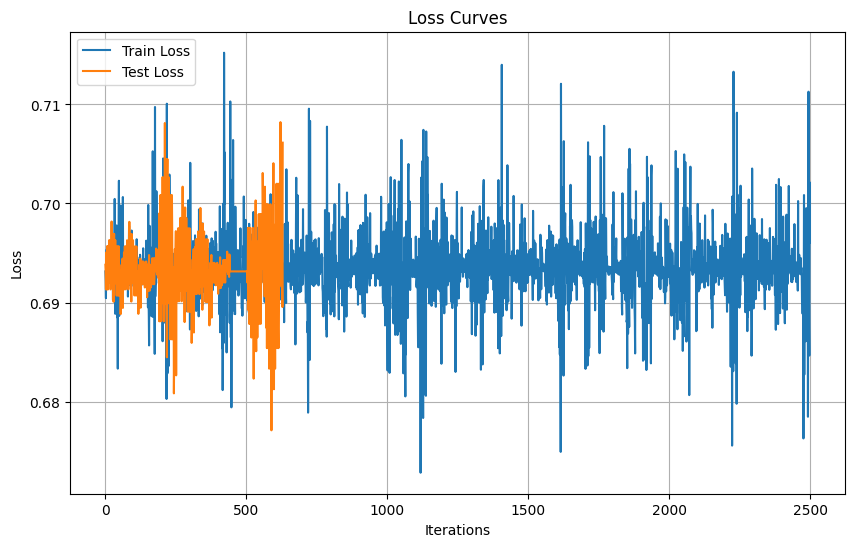

In [ ]:
plot_loss_curves(losses_train, losses_test, file_name="mlp_loss_curves_large_2")

**Report what you observe on the training/test loss curves (related to a term we mentioned in the lecture)**

The toy moon dataset from Sklearn is a non-linearly separable dataset with two intertwined classes. The current MLP architecture with only two hidden layers may lack sufficient capacity to learn the complex patterns in the data, leading to high training loss and underfitting. Conversely, an excessively high capacity with multiple hidden layers may cause the model to overfit the training data, resulting in a low training loss but high test loss. Moreover, using Xavier or Glorot initialization for the weights instead of normal distribution initialization can enhance the model's learning capacity since the initialization helps to set the weights of the network to small random values that are inversely proportional to the square root of the number of input units in the previous layer. This ensures that the variance of the outputs of each layer remains consisten allowing gradients to flow through the network during backpropagation.


### Task 2: Data Preparation and Visualization

In [ ]:
# prepare data for training and testing
def load_data(train=True):
    """Load train- test split for MNIST"""
    mnist = datasets.MNIST('../data',
                train=train,
                download=True)
    return mnist

In [ ]:
# 1.1 Load MNIST dataset
# load train split
data_train = load_data(train=True)
data_test = load_data(train=False)

print(len(data_train))
print(len(data_test))

60000
10000


In [ ]:
def plot_examples(data):
    """ Plot some examples and put their corresponding label on top as title."""
    train_set_array = np.fliplr(data.data.numpy()) # data is l-r flipped
    train_set_array_targets = data.targets.numpy()
    
    # set title for image with subplot

    fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for i in range(10):
        axs[i].contourf(train_set_array[i], 5, cmap=plt.cm.Greys)
        axs[i].set_title(train_set_array_targets[i]) 
    
    # Set a single title for the entire figure
    fig.suptitle('MNIST Dataset', fontsize=20)

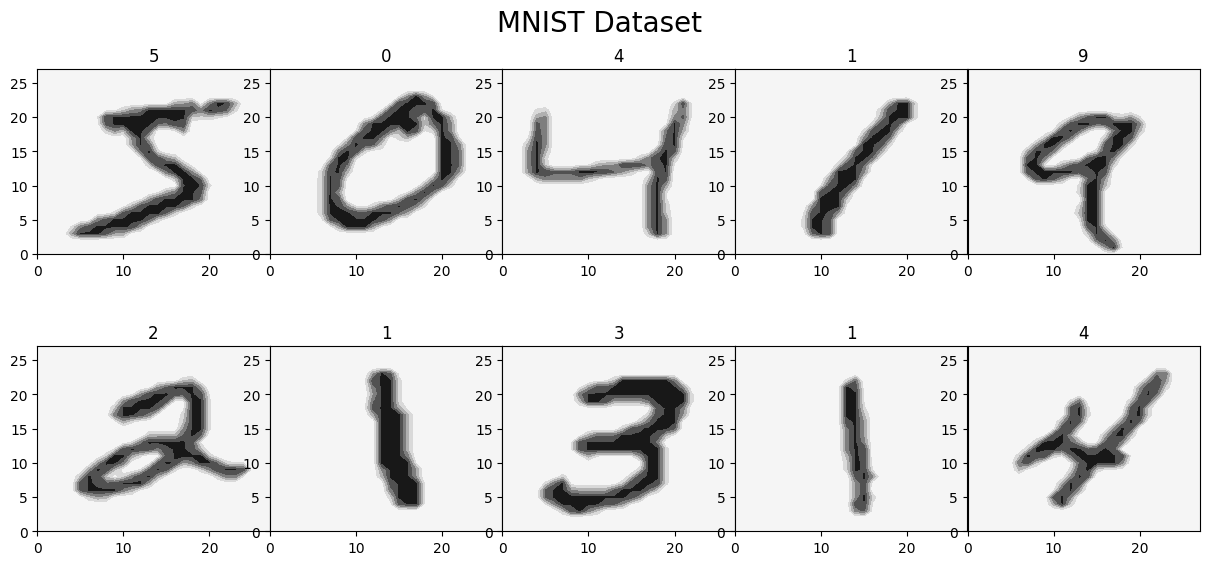

In [ ]:
# 1.2 Plot some examples from the training set
plot_examples(data_train)

In [ ]:
def plot_report(data: np.array) -> None:
    v_sum = np.sum(data)
    v_min = np.min(data)
    v_max = np.max(data)
    v_mean = np.mean(data)
    v_shape = data.shape
    v_dtype = data.dtype

    print("Report for train set")
    print(f"Train Sum: {v_sum}")
    print(f"Train Min: {v_min}")
    print(f"Train Max: {v_max}")
    print(f"Train Mean: {v_mean}")
    print(f"Train Shape: {v_shape}")
    print(f"Train Datatype: {v_dtype}")

In [ ]:
# 1.3 Give a report about min, max, mean, and std of the training set
train_set_array = data_train.data.numpy() # data is l-r flipped
plot_report(train_set_array)

Report for train set
Train Sum: 1567298545
Train Min: 0
Train Max: 255
Train Mean: 33.318421449829934
Train Shape: (60000, 28, 28)
Train Datatype: uint8


In [ ]:
def convert_mnist_to_vectors(data):
    '''Converts the ``[28, 28]`` MNIST images to vectors of size ``[28*28]``.
       It outputs mnist_vectors as a array with the shape of [N, 784], where
       N is the number of images in data.
    '''

    mnist_vectors = []
    labels = []

    for image, label in tqdm(data):
        img_array = np.asarray(image)
        img_array = np.reshape(img_array, -1) # reshape array to vector
        mnist_vectors.append(img_array)
        labels.append(label)

    # return as numpy arrays
    return np.array(mnist_vectors), labels


def normalise_data(data: np.array) -> np.array:
    """ Normalise vectors to be in a range of [-1, 1]
        Improves convergence of the model since gradients are in a similar range.
    """
    data = data.copy()
    return 2*(data - np.min(data))/np.ptp(data) - 1

In [ ]:
# 2. Convert all images into plain vectors and process them to be centered around 0
mnist_vectors, labels = convert_mnist_to_vectors(data_train)

# normalize data
mnist_vectors = normalise_data(np.array(mnist_vectors))

print(mnist_vectors[:1].shape)
print(mnist_vectors.shape)

100%|██████████| 60000/60000 [00:00<00:00, 69842.81it/s]


(1, 784)
(60000, 784)


In [ ]:
plot_report(mnist_vectors)

Report for train set
Train Sum: -40993291.16078458
Train Min: -1.0
Train Max: -0.0039215686274509665
Train Mean: -0.8714560195745021
Train Shape: (60000, 784)
Train Datatype: float64


In [ ]:
# Normalised [-1,1]
norm_mnist_mean = np.mean(mnist_vectors)
print(f"Train Mean: {norm_mnist_mean}")

Train Mean: -0.8714560195745021


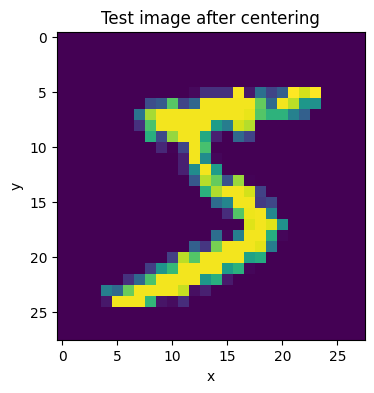

In [ ]:
test_img = mnist_vectors[:1]
test_img = test_img.reshape((28, 28))
plt.imshow(test_img, interpolation='nearest')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Test image after centering")
plt.show()

In [ ]:
def do_pca(data):
    '''Returns matrix [784x784] whose columns are the sorted eigenvectors.
       Eigenvectors (prinicipal components) are sorted according to their
       eigenvalues in decreasing order.
    '''

    mnist_vectors, _ = convert_mnist_to_vectors(data)
    # prepare_data(mnist_vectors)

    # compute covariance matrix of data with shape [784x784]
    cov = np.cov(mnist_vectors.T)

    # compute eigenvalues and vectors
    eigVals, eigVec = np.linalg.eig(cov)

    # sort eigenVectors by eigenValues
    # the earlier eigenVectors have more information about the data
    sorted_index = eigVals.argsort()[::-1]
    eigVals = eigVals[sorted_index]
    sorted_eigenVectors = eigVec[:, sorted_index]
    print(type(sorted_eigenVectors), sorted_eigenVectors.shape)
    return sorted_eigenVectors.astype(np.float32).T

In [ ]:
# 3. Run PCA on the MNIST dataset
eigenVectors = do_pca(data_train)

100%|██████████| 60000/60000 [00:00<00:00, 86313.80it/s]


<class 'numpy.ndarray'> (784, 784)


/var/folders/4h/v0fwv1zs4596mmdvwj516k840000gn/T/ipykernel_17138/3987593753.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  return sorted_eigenVectors.astype(np.float32).T


In [ ]:
def plot_pcs(sorted_eigenVectors, num=10):
    '''Plots the first ``num`` eigenVectors as images.'''
    fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for i in range(num):
        img = sorted_eigenVectors[i,].reshape((28, 28))
        axs[i].contourf(img, 5, cmap=plt.cm.Oranges)
        axs[i].set_title(f"Principal Component {i}")
    
    # Set a single title for the entire figure
    fig.suptitle('Selected MNIST Dataset Eigenvectors', fontsize=20)

    # save plot to results folder
    plt.savefig(f"{RESULTS_PATH}/pca_components.png", dpi=300)

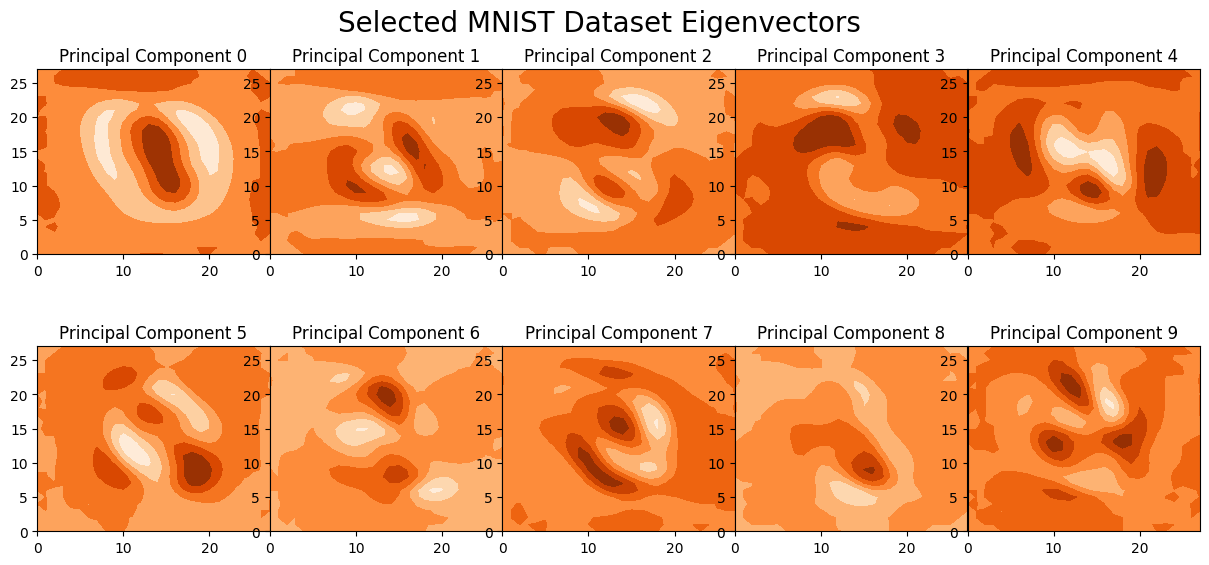

In [ ]:
# 3.2 Plot the first 10 principal components
plot_pcs(eigenVectors)

**Explain what can be observed?**

The plot visualize the ten most important principal components, which allows to explain the greatest amount of variance in the original features. Thereby, PCA identifies directions (or principal components) along which the variation in the data is maximal. Hereby, it can be observed that the spread of the values is relatively large on the y-axis with relatively less spread (variance) on the x-axis. However, since the input data follows some wave-type structure (hand-written digits) after the projection the wave shapes also show up as distortion in the plots. Thereby, a linear correlation of the principal component values is not observable. The different values for the principal components do not show any clear linear relationship between the variance of the features in the dataset. We can derive that the classes are not linear seperable. The MNIST data further does not follow a multidimensional normal (Gaussian) distribution.

**What would you expect the principal components to look like, if the problem was easy?**

If the problem was easy a linear relationship, or strong linear correlation would be observable. However, the MNIST classes are not linearly seperable which makes the problem more challenging. Additionally, a large spread, or great variance is visible.

In [ ]:
# create random colours
from random import randint

def generate_colors(amount: int) -> list:
    colors = []
    for i in range(amount):
        colors.append('#%06X' % randint(0, 0xFFFFFF))
    return colors

In [ ]:
def project_vec_2Dspace(x, y):
    """ Use of the dot product to project vectors onto each other."""
    return np.dot(x, y)

In [ ]:
def plot_projection(sorted_eigenVectors, data, subset=None, path=RESULTS_PATH):
    ''' Projects ``data`` onto the first two ``sorted_eigenVectors`` and makes
        a scatterplot of the resulting points
    '''
    if subset is None:
        N = len(list(data))
    else:
        N = subset

    # prepare data as vectors
    mnist_vectors, labels = convert_mnist_to_vectors(data)
    
    # projection of the first two vetors in 2D feature space
    pc1s = np.array([project_vec_2Dspace(x, y=sorted_eigenVectors[0]) for x in mnist_vectors[:N,]])
    pc2s = np.array([project_vec_2Dspace(x, y=sorted_eigenVectors[1]) for x in mnist_vectors[:N,]])

    # get random colours
    unique_labels = np.unique(labels[:N])
    cdict = generate_colors(len(unique_labels))

    # plot all datapoints 
    fig, ax = plt.subplots()
    for g in unique_labels:
        ix = np.where(labels[:N] == g)
        x = list(pc1s[ix])
        y = list(pc2s[ix])
        ax.scatter(x, y, c=cdict[g], marker='.', label=f'class {g}')
    
    ax.legend()
    ax.grid()
    plt.title(f'Two Component PCA with {N} Samples')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

    fig.savefig(f'./{path}/pca.png', dpi=fig.dpi)

(2, 784)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1054cfd50>>
Traceback (most recent call last):
  File "/Users/janinaalicamattes/miniforge3/envs/pytorch-py11/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
100%|██████████| 60000/60000 [00:00<00:00, 83108.02it/s]


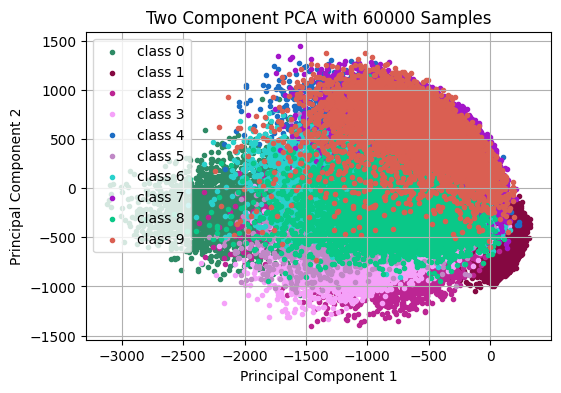

In [ ]:
# 4. Project the MNIST vectors of the train set onto the two most important principal components
# find the two main important PCs, we can already separate the images somehow 
two_main_components = eigenVectors[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(sorted_eigenVectors=two_main_components, data=data_train)   

**Interpret the plot. What can it tell us about the MNIST dataset? Can you make a statement regarding the difficulty of MNIST digit classification problem?**

The diagram shows strong clusters and overlaps between the projected classes displaied, but little linear correlation within a class. Only very few classes can be separated, most are overlapping and mixed in the same PCA space. In this case, PCA may not well suited to capture non-linear relationships in a high-dimensional data set since it is itself a linear dimensionality reduction technique.

### Task 3: Defining, Training and Evaluating an MLP

In [ ]:
# 1 build 5-layer MLP
class MultilayerPerceptron(nn.Module):
    """ The multilayer perceptron does a matrix multiplication of its 
        internal weights with the inputs and adds a bias in
        each layer. After that it activates the resulting vector.
        This can be done using the `Linear` layer. 
    """
    
    def __init__(self, size_hidden=100, size_out=10):
        """ Each hidden layer has 100 hidden units (output feature dimension).
            All hidden layers use ReLU activations.
        """
        super().__init__()
        # number of hidden nodes in each layer (100)
        # linear layer (784 -> hidden_1)
        self.fc1 = torch.nn.Linear(28*28, size_hidden) # Your Code here
        # linear layer (n_hidden -> n_hidden)
        self.fc2 = torch.nn.Linear(100, size_hidden)
        # linear layer (n_hidden -> n_hidden)
        self.fc3 = torch.nn.Linear(100, size_hidden)
        # linear layer (n_hidden -> n_hidden)
        self.fc4 = torch.nn.Linear(100, size_hidden)
        # linear layer (n_hidden -> size_out)
        self.out_layer = torch.nn.Linear(100, size_out)
        
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        # flatten the image, 
        # the -1 is a wildcard
        x = x.view(-1, 28*28)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        # flatten the output signal
        out = out.view(out.size(0), -1)
        out = self.out_layer(out)
        
        # no softmax as multi-class 
        # classification not probabilities

        return out

In [ ]:
class MnistVectors(torch.utils.data.Dataset):
    ''' A Pytorch Dataset, which does the same 
        data preparation as was done in the PCA exercise.
    '''

    def __init__(self, split='train'):
        super().__init__()
        # torch dataset with casting operation
        mnist_train = datasets.MNIST('../data',
                               train=split=='train',
                               download=True)

        self.mnist_vectors, self.labels = convert_mnist_to_vectors(mnist_train)

            
    def __getitem__(self, idx):
        ''' Implements the ``[idx]`` method. Here we convert the numpy data to
            torch tensors.
        '''
        mvec = torch.tensor(self.mnist_vectors[idx]).float()
        label = torch.tensor(self.labels[idx]).long()

        return mvec, label
    
    def __len__(self):
        return len(self.labels)

In [ ]:
# 3. Implement a function, which can report the accuracy of a batch of predictions in percent.

def batch_accuracy(prediction, label):
    """Uses labels to calculate the batch accuracy"""
    N = prediction.size(0)
    acc = prediction.eq(label.view_as(label)).sum().item()
    return (acc / N) * 100


def class_label(prediction):
    """ Transforms the output of the MultilayerPerceptron 
        into a scalar class label (index which matches predicted label: 0-9).
    """
    return prediction.argmax(dim=1)

def normalize_output(img):
    """ Normalizes the image to be in the range [0, 1]
        and converts it to a numpy array.
    """
    img = img - img.min()
    img = img / img.max()
    return img

In [ ]:
# Visualize feature maps
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
# Visualize feature maps
act_fc1, act_fc2, act_fc3, act_fc4 = [], [], [], []
labels = []

In [ ]:
def get_feature_maps(model, dataset=None, use_gpu=False):
    """ Get the feature maps of the model for a given dataset."""
    # define hook
    activation = {}

    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # register hooks
    model.fc1.register_forward_hook(get_activation('fc1'))
    model.fc2.register_forward_hook(get_activation('fc2'))
    model.fc3.register_forward_hook(get_activation('fc3'))
    model.fc4.register_forward_hook(get_activation('fc4'))

    if not dataset:
        dataset = datasets.MNIST(
        root='../data',
        train=False,
        transform=transforms.ToTensor()
    )

    count = 0
    with torch.no_grad():
        for data_sample, label in dataset:
            
            data_sample = np.reshape(data_sample, -1)
            data_sample.unsqueeze_(0)

            if use_gpu:
                data_sample = data_sample.cuda()
                label = label.cuda()
                
            pred = model(data_sample)

            act1 = activation['fc1'].squeeze()
            act2 = activation['fc2'].squeeze()
            act3 = activation['fc3'].squeeze()
            act4 = activation['fc4'].squeeze()

            # collect activated feature maps
            act_fc1.append(act1.detach().cpu().numpy())
            act_fc2.append(act2.detach().cpu().numpy())
            act_fc3.append(act3.detach().cpu().numpy())
            act_fc4.append(act4.detach().cpu().numpy())

            # collect all labels
            labels.append(label)
            count += 1

        print(f" Done after {count} steps!")

In [ ]:
def validate(test, model, criterion, use_gpu=False):
        test_accuracies = []
        test_losses = []
        
        model.eval()
        
        with torch.no_grad():
            for idx, [test_examples, test_labels] in enumerate(tqdm(test, desc='Test')):
                if use_gpu:
                    test_examples = test_examples.cuda()
                    test_labels = test_labels.cuda()
                
                test_prediction = model(test_examples)
                
                # evaluation
                test_loss = criterion(test_prediction, test_labels).data.item()
                test_acc = batch_accuracy(class_label(test_prediction), test_labels)

                if (idx % 10) == 0:
                    print('Test Batch Accuracy: {}%, Test Loss: {}'.format(test_acc, test_loss))
                
                test_accuracies.append(test_acc) # per batch
                test_losses.append(test_loss)

        # Use the batch_accuracy function, also print the mean accuracy
        # over the whole test split of the data.

        print('Mean Validation Accuracy: {}%'.format(np.mean(test_accuracies)))
        print('Mean Validation Loss: {}%'.format(np.mean(test_losses)))

        plt.plot(test_accuracies)

In [ ]:
def train(use_gpu=False): # if torch.cuda.is_available(), use gpu to speed up training
    
    # Here we instantiate our model. The weights of the model are automatically
    # initialized by pytorch
    model = MultilayerPerceptron()
    
    TrainData = MnistVectors()
    TestData = MnistVectors('test')

    # Dataloaders allow us to load the data in batches. This allows us a better
    # estimate of the parameter updates when doing backprop.
    # We need two Dataloaders so that we can train on the train data split
    # and evaluate on the test datasplit.
    
    Dl = DataLoader(TrainData, batch_size=32, shuffle=True)
    testDl = DataLoader(TestData, batch_size=32, shuffle=False)
    
    # Use the Adam optimizer with learning rate 1e-4 and otherwise default
    # values
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Use the Cross Entropy loss from pytorch. Make sure your MultilayerPerceptron does
    # not use any activation function on the output layer! (Do you know why?) 
    criterion = nn.CrossEntropyLoss()
    
    if use_gpu:
        model.cuda()
        criterion.cuda()
    
    for epoch in tqdm(range(5), desc='Epoch'):
        for step, [example, label] in enumerate(tqdm(Dl, desc='Batch')):
            if use_gpu:
                example = example.cuda()
                label = label.cuda()
            
            # The optimizer knows about all model parameters. These in turn
            # store their own gradients. When calling loss.backward() the newly
            # computed gradients are added on top of the existing ones. Thus
            # at before calculating new gradients we need to clear the old ones
            # using ther zero_grad() method.
            
            optimizer.zero_grad()
            
            prediction = model(example)
            loss = criterion(prediction, label)
            
            # Here pytorch applies backpropagation for us completely
            loss.backward()

            # The step method now adds the gradients onto the model parameters
            # as specified by the optimizer and the learning rate.
            optimizer.step()
            
            # To keep track of what is happening print some outputs from time to time.
            if (step % 375) == 0:
                acc = batch_accuracy(class_label(prediction), label)
                tqdm.write('Batch Accuracy: {}%, Loss: {}'.format(acc, loss))
        
        # checkpoints to reuse model weights
        torch.save(model.state_dict(), 'perceptron_{}.ckpt'.format(step))

    # Now validate on the whole test set
    validate(testDl, model, criterion, use_gpu)

    # If you need to load the checkpoint instanciate your model and the
    # load the state dict from a checkpoint:
    # model = MultilayerPerceptron()
    # model.load_state_dict(torch.load(perceptron_3750.ckpt))
    # Make sure to use the latest checkpoint by entering the right number.

    ######################################
    ######      Code for task 4     ######
    ######################################

    get_feature_maps(model, use_gpu=use_gpu)

100%|██████████| 10000/10000 [00:00<00:00, 86261.20it/s]
                                            
Epoch:   0%|          | 0/5 [00:00<?, ?it/s]   

Batch Accuracy: 3.125%, Loss: 3.272854804992676


                                            
Epoch:   0%|          | 0/5 [00:00<?, ?it/s]              

Batch Accuracy: 87.5%, Loss: 0.3696991205215454


                                            
Epoch:   0%|          | 0/5 [00:00<?, ?it/s]              

Batch Accuracy: 90.625%, Loss: 0.2294764518737793


                                            
Epoch:   0%|          | 0/5 [00:01<?, ?it/s]               

Batch Accuracy: 93.75%, Loss: 0.15504100918769836


                                            
Epoch:   0%|          | 0/5 [00:02<?, ?it/s]               

Batch Accuracy: 90.625%, Loss: 0.4253005087375641


Epoch:  20%|██        | 1/5 [00:02<00:11,  2.89s/it]

Batch Accuracy: 100.0%, Loss: 0.024768179282546043



Epoch:  20%|██        | 1/5 [00:03<00:11,  2.89s/it]      

Batch Accuracy: 100.0%, Loss: 0.014725908637046814



Epoch:  20%|██        | 1/5 [00:04<00:11,  2.89s/it]      

Batch Accuracy: 96.875%, Loss: 0.08787013590335846



Epoch:  20%|██        | 1/5 [00:04<00:11,  2.89s/it]       

Batch Accuracy: 93.75%, Loss: 0.22625988721847534



Epoch:  20%|██        | 1/5 [00:05<00:11,  2.89s/it]       

Batch Accuracy: 93.75%, Loss: 0.2674611806869507


Epoch:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

Batch Accuracy: 93.75%, Loss: 0.1465735286474228



Epoch:  40%|████      | 2/5 [00:06<00:08,  2.94s/it]      

Batch Accuracy: 100.0%, Loss: 0.01181174349039793



Epoch:  40%|████      | 2/5 [00:06<00:08,  2.94s/it]      

Batch Accuracy: 100.0%, Loss: 0.0342227965593338



Epoch:  40%|████      | 2/5 [00:07<00:08,  2.94s/it]       

Batch Accuracy: 96.875%, Loss: 0.07324794679880142



Epoch:  40%|████      | 2/5 [00:07<00:08,  2.94s/it]       

Batch Accuracy: 93.75%, Loss: 0.11598781496286392


Batch: 100%|██████████| 1875/1875 [00:02<00:00, 723.96it/s]
                                                    
Epoch:  60%|██████    | 3/5 [00:08<00:05,  2.79s/it]

Batch Accuracy: 100.0%, Loss: 0.023698797449469566


                                                    
Epoch:  60%|██████    | 3/5 [00:08<00:05,  2.79s/it]      

Batch Accuracy: 100.0%, Loss: 0.01929398998618126


                                                    
Epoch:  60%|██████    | 3/5 [00:09<00:05,  2.79s/it]      

Batch Accuracy: 96.875%, Loss: 0.06932026147842407


                                                    
Epoch:  60%|██████    | 3/5 [00:10<00:05,  2.79s/it]       

Batch Accuracy: 100.0%, Loss: 0.003918809816241264


                                                    
Epoch:  60%|██████    | 3/5 [00:10<00:05,  2.79s/it]       

Batch Accuracy: 93.75%, Loss: 0.28539225459098816


Batch: 100%|██████████| 1875/1875 [00:02<00:00, 766.22it/s]
                                                    
Epoch:  80%|████████  | 4/5 [00:10<00:02,  2.65s/it]

Batch Accuracy: 96.875%, Loss: 0.061332136392593384


                                                    
Epoch:  80%|████████  | 4/5 [00:11<00:02,  2.65s/it]      

Batch Accuracy: 100.0%, Loss: 0.0034617804922163486


                                                    
Epoch:  80%|████████  | 4/5 [00:11<00:02,  2.65s/it]      

Batch Accuracy: 90.625%, Loss: 0.11714981496334076


                                                    
Epoch:  80%|████████  | 4/5 [00:12<00:02,  2.65s/it]       

Batch Accuracy: 100.0%, Loss: 0.009263690561056137


                                                    
Epoch:  80%|████████  | 4/5 [00:12<00:02,  2.65s/it]       

Batch Accuracy: 100.0%, Loss: 0.006826438941061497


Test: 100%|██████████| 313/313 [00:00<00:00, 2751.65it/s]


Test Batch Accuracy: 100.0%, Test Loss: 0.0033691441640257835
Test Batch Accuracy: 96.875%, Test Loss: 0.06062225624918938
Test Batch Accuracy: 100.0%, Test Loss: 0.03664908930659294
Test Batch Accuracy: 96.875%, Test Loss: 0.17429830133914948
Test Batch Accuracy: 93.75%, Test Loss: 0.218812957406044
Test Batch Accuracy: 90.625%, Test Loss: 0.20029626786708832
Test Batch Accuracy: 96.875%, Test Loss: 0.05493167042732239
Test Batch Accuracy: 100.0%, Test Loss: 0.011304434388875961
Test Batch Accuracy: 96.875%, Test Loss: 0.0502542220056057
Test Batch Accuracy: 100.0%, Test Loss: 0.010172164998948574
Test Batch Accuracy: 93.75%, Test Loss: 0.1324033886194229
Test Batch Accuracy: 93.75%, Test Loss: 0.3049100637435913
Test Batch Accuracy: 87.5%, Test Loss: 0.24232038855552673
Test Batch Accuracy: 96.875%, Test Loss: 0.2076542228460312
Test Batch Accuracy: 90.625%, Test Loss: 0.35713765025138855
Test Batch Accuracy: 93.75%, Test Loss: 0.23597440123558044
Test Batch Accuracy: 96.875%, Test L

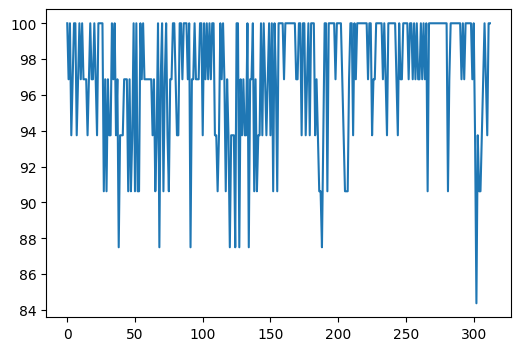

In [ ]:
train(use_gpu=True if torch.cuda.is_available() else False)

#### Task 4: Visualizing MLP Features

In [ ]:
# 1. MNIST images of the test split, or if you have limited computational resource for a subset of at least 1000 image
print(np.asarray(act_fc1).shape)

(10000, 100)


In [ ]:
def norm_data(data):
    """ Normalizes the data to be in the range [0, 1]."""
    data = data - np.min(data)
    data = data / np.max(data)
    return data

In [ ]:
# 2. find PCA of vectors and project feature maps onto the first two principal components
def convert_act_to_vectors(data):
    '''Converts the activated feature maps to vectors of size ``[n*m]``.
       It outputs mnist_vectors as a array with the shape of [N, n*m], where
       N is the number of maps in data.
    '''

    act_vectors = []

    for act in tqdm(data):
        act_array = np.asarray(act)
        act_array = np.reshape(act_array, -1) # reshape array to vector
        act_vectors.append(act_array)
    
    # return as numpy arrays
    return norm_data(np.array(act_vectors))

In [ ]:
def do_pca_actm(data):
    '''Returns matrix [nxm] whose columns are the sorted eigenvectors.
       Eigenvectors (prinicipal components) are sorted according to their
       eigenvalues in decreasing order.
       >>> PCA compresses the input data into its representation.
    '''

    actm_vectors = convert_act_to_vectors(data)
    # prepare_data(actm_vectors)

    # compute covariance matrix of data
    cov = np.cov(actm_vectors.T)

    # compute eigenvalues and vectors
    eigVals, eigVec = np.linalg.eig(cov)

    # sort eigenVectors by eigenValues descending
    sorted_index = eigVals.argsort()[::-1]
    eigVals = eigVals[sorted_index]
    sorted_eigenVectors = eigVec[:, sorted_index]
    print(type(sorted_eigenVectors), sorted_eigenVectors.shape)
    
    return sorted_eigenVectors.astype(np.float64).T

In [ ]:
pca_act_fc1 = do_pca_actm(act_fc1)
pca_act_fc2 = do_pca_actm(act_fc2)
pca_act_fc3 = do_pca_actm(act_fc3)
pca_act_fc4 = do_pca_actm(act_fc4)

print(pca_act_fc1.shape)
print(pca_act_fc2.shape)
print(pca_act_fc3.shape)
print(pca_act_fc4.shape)

100%|██████████| 10000/10000 [00:00<00:00, 1000215.58it/s]


<class 'numpy.ndarray'> (100, 100)


100%|██████████| 10000/10000 [00:00<00:00, 601463.25it/s]


<class 'numpy.ndarray'> (100, 100)


100%|██████████| 10000/10000 [00:00<00:00, 643870.93it/s]


<class 'numpy.ndarray'> (100, 100)


100%|██████████| 10000/10000 [00:00<00:00, 358459.95it/s]

<class 'numpy.ndarray'> (100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)


(2, 100)


10000it [00:00, 919561.52it/s]


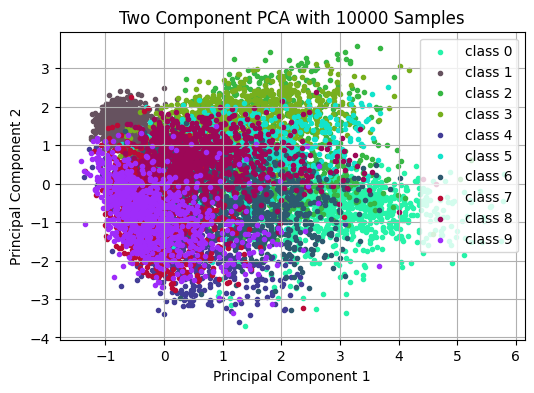

In [ ]:
# 3. Make a scatter plot of the projected feature maps onto the first two principal components
# find the two main important PCs
two_main_components = pca_act_fc1[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(two_main_components, zip(act_fc1, labels), subset=len(labels))

(2, 100)


10000it [00:00, 1201221.18it/s]


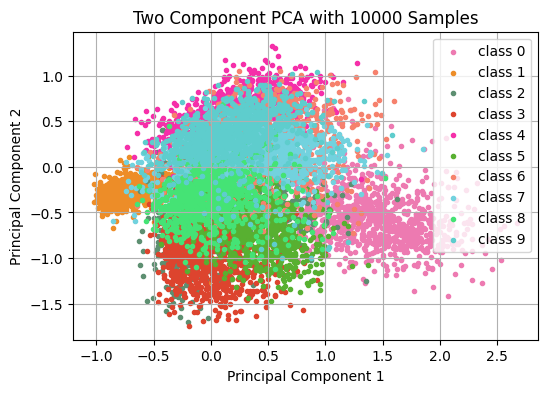

In [ ]:
# find the two main important PCs
two_main_components = pca_act_fc2[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(two_main_components, zip(act_fc2, labels), subset=len(labels))

(2, 100)


10000it [00:00, 1331187.00it/s]


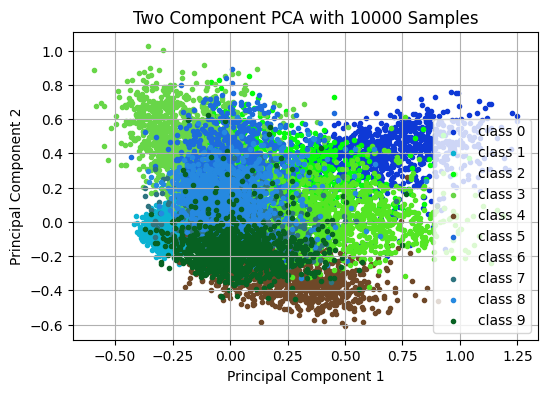

In [ ]:
# find the two main important PCs
two_main_components = pca_act_fc3[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(two_main_components, zip(act_fc3, labels), subset=len(labels))

(2, 100)


10000it [00:00, 1251732.12it/s]


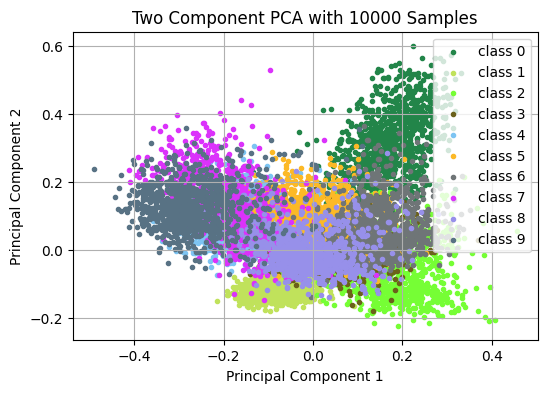

In [ ]:
# find the two main important PCs
two_main_components = pca_act_fc4[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(two_main_components, zip(act_fc4, labels), subset=len(labels))

**Compare the plots to the scatter plot from task 2. What has changed, what is similar?**

The PCA plots show a progressive scattering of salient features along the x- and y-axis through the model layers. The later layers show distinct projections per class into various clusters. This is because the later layers of the model learn more complex and abstract features of the data, which can better separate the different classes or categories.

**Do you believe that the MLP is a suitable method for MNIST digit classification? Provide an explanation.**

MLPs are relatively simple and suitable for structured data, making them a good baseline model for MNIST digit classification. However, CNNs are better suited for processing large image datasets as they can capture spatial relationships between pixels and develop an internal representation of the training dataset. CNNs also use weight sharing, making them more parameter-efficient than MLPs. Therefore, while an MLP can be used as a starting point, a CNN is likely to achieve better performance on the MNIST dataset.
